In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import plotly.graph_objects as go
import os
import re

# for bessel functions and curve fitting
from scipy.optimize import curve_fit
from scipy import special

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Latin Modern Roman"],  # must be installed on your system
    "mathtext.fontset": "cm",             # Computer Modern math, matches LaTeX style
    "text.usetex": True                    # render text via LaTeX
})

In [2]:
def clean_inline_data(df):
    # rename columns to identical names from LEB setups
    df = df.rename(columns={'VIN': 'Vin', '-Ch1 IIN': 'Iin', '-Ch1 IOUT': 'Iout', '-Ch2 VINS': 'VinS', '-Ch3 VOUTS -Ch4': 'VoutS'})

    # iterate over all cells to manully remove and handle units + add leading 0
    for col in df.columns:
        for index, val in enumerate(df[col]):
            # scaling factor per row
            multiplier = 1.0
            if 'mA' in val:
                multiplier = 1e-3
            elif 'uA' in val:
                multiplier = 1e-6

            # remove units 
            clean_val = val.replace('V', '').replace('mA', '').replace('uA', '').replace(' ', '')
            # convert unit if needed (mA / uA)
            # df[col][index] = float(clean_val) * multiplier
            df.loc[index, col] = float(clean_val) * multiplier
    # convert to float
    df = df.apply(pd.to_numeric, errors='coerce')

    df['delta_V'] = df['VinS'] - df['VoutS']
    return df

In [3]:
folder_path = r"C:\Users\Lutz_Laptop\Documents\Seafile\Master\Data\TLM\CTLM Messdaten\cTLM_Ni_final"

structure_data = {}

for subfolder in os.listdir(folder_path):
    subfolder_path = os.path.join(folder_path, subfolder)
    if os.path.isdir(subfolder_path):
        list_of_measurements = {}
            
        # get r_inner from folder name => is equal in all subfolders
        match = re.search(r"\[ri=(\d+)\]", subfolder_path)
        if match:
            r_inner = int(match.group(1))   # or float(...)
            print(r_inner)
        else:
            raise ValueError("No r_inner found")    
        
        # iterate over all files in the folder
        for file in os.listdir(subfolder_path):
            if file.endswith('.roh'):
                try:
                    data = pd.read_csv(os.path.join(subfolder_path, file), delimiter=r'\s{2,}', skiprows=24, encoding='ISO-8859-1', engine='python')
                    data = clean_inline_data(data)
                    
                    limit = 0.1  # 100mA
                    # Keep only rows where compliance limit is not reached
                    data = data[data['Iin'].abs() < limit].reset_index(drop=True)

                    list_of_measurements[int(os.path.splitext(os.path.basename(file))[0])] = data
                    
                except Exception as e:
                    print(f"Error reading file {file}: {e}")
                    continue
        
        # get name of structure from subfolder
        match = re.search(r"\[description=(.*?)\]", subfolder)
        if match:
            structure_name = match.group(1)
            print(structure_name)
        else: 
            structure_name = subfolder
        structure_data[structure_name] = dict(sorted(list_of_measurements.items()))

print(structure_data.keys()) 

150
Mitte
150
Oben
150
Unten
dict_keys(['Mitte', 'Oben', 'Unten'])


In [4]:
print(structure_data['Mitte'].keys())
print(structure_data['Mitte'][40].head())


dict_keys([40, 50, 60, 70, 80, 90, 100, 160, 240, 320, 400, 480])
    Vin      Iin     Iout   VinS  VoutS  delta_V
0 -0.12 -0.09665  0.09666 -0.060 -0.032   -0.028
1 -0.11 -0.08857  0.08858 -0.055 -0.030   -0.025
2 -0.10 -0.08049  0.08052 -0.050 -0.027   -0.023
3 -0.09 -0.07242  0.07242 -0.045 -0.024   -0.021
4 -0.08 -0.06432  0.06436 -0.040 -0.021   -0.019


In [5]:
def get_resistance(list_of_measurements):
    R_list = []
    for key in list_of_measurements.keys():
        slope, intercept = np.polyfit(list_of_measurements[key]['delta_V'], list_of_measurements[key]['Iin'], 1)
        R_list.append((1/slope))  # in ohm

    return R_list

$$ R_{T, \text { circ }}=\frac{R_{s h}}{2 \pi}\left[\ln \left(\frac{r_i+s}{r_i}\right)+\frac{L_t}{r_i} \frac{I_0\left(\frac{r_i}{L_t}\right)}{I_1\left(\frac{r_i}{L_t}\right)}+\frac{L_t}{r_i+s} \frac{K_0\left(\frac{r_i+s}{L_t}\right)}{K_1\left(\frac{r_i+s}{L_t}\right)}\right]$$

In [6]:
# @param geometries: arrays with the ditances and inner radius of the CTLM structure
# @param Rsh: sheet resistance -> initial guess
# @param Lt: transfer length -> initial guess
# this still uses the assumption of R_sh being constant under and between the contacts
def ctlm_bessel_model(geometries, Rsh, L_T):
        
        (distances, r_inner) = geometries
        # Term 1: Resistance of the semiconductor gap
        term_gap = np.log((r_inner + distances) / r_inner)
        
        # Term 2: Resistance of the inner contact (using using bessel functions I0 and I1)
        term_inner = (L_T / r_inner) * (special.i0(r_inner / L_T) / special.i1(r_inner / L_T))
        
        # Term 3: Resistance of the outer contact (using bessel functions K0 and K1)
        term_outer = (L_T / (r_inner + distances)) * (special.k0((r_inner + distances) / L_T) / special.k1((r_inner + distances) / L_T))
        
        # Total Resistance
        R_T = (Rsh / (2 * np.pi)) * (term_gap + term_inner + term_outer)

        return R_T

In [7]:
# R_list = get_resistance(structure_data['Mitte'])



# popt, pcov = curve_fit(ctlm_bessel_model, (distances, r_inner_array), R_list, p0=p0, bounds=bounds)

# Rsh_fit, Lt_fit = popt

# rho_c_fit = Rsh_fit * (Lt_fit**2) * 1e-8  # 1e-8 to convert from ohm·μm² to ohm·cm²

# distances_smooth = np.linspace(0, max(distances), 300) # min(distances)
# ri_smooth = np.full_like(distances_smooth, r_inner)
# Rt_fit_curve = ctlm_bessel_model((distances_smooth, ri_smooth), Rsh_fit, Lt_fit)

In [8]:
def sci_notation_latex(x, precision=2):
    mantissa, exp = f"{x:.{precision}e}".split("e")
    return rf"{mantissa} \cdot 10^{{{int(exp)}}}"

In [9]:
# set fit parameters
# distances = list(map(int, structure_data['Mitte'].keys()))
distances = list(map(int,structure_data[next(iter(structure_data))].keys()))
distances = np.array(distances)
# Initial Guess: [Rsh, Lt]
p0 = [1, 1]
bounds = ([0, 0], [np.inf, np.inf])
r_inner_array = np.full_like(distances, r_inner)

Fitted parameters for Mitte: Rsh = 1.08 Ohm/sq, Lt = 99.69 um, rho_c = 1.07e-04 Ohm·cm²


C:\Users\Lutz_Laptop\AppData\Local\Temp\ipykernel_15460\1810454289.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', len(structure_data.keys()))


Fitted parameters for Oben: Rsh = 1.02 Ohm/sq, Lt = 124.87 um, rho_c = 1.60e-04 Ohm·cm²
Fitted parameters for Unten: Rsh = 1.77 Ohm/sq, Lt = 71.37 um, rho_c = 9.00e-05 Ohm·cm²


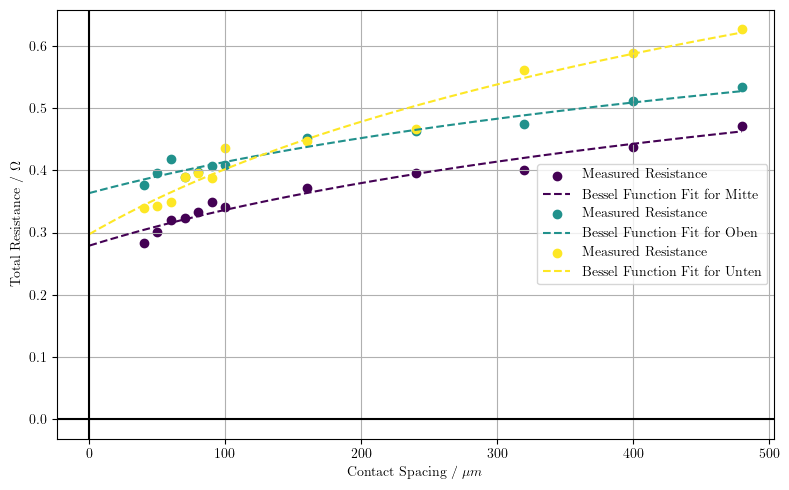

In [10]:
results = []

plt.figure(figsize=(8, 5))

colors = plt.cm.get_cmap('viridis', len(structure_data.keys()))

# for key, data in structure_data.items():
for i, (key, data) in enumerate(structure_data.items()):
    # get resistance values
    R_list = get_resistance(data)
    results.append((key, R_list))
    
    # fit data
    popt, pcov = curve_fit(ctlm_bessel_model, (distances, r_inner_array), R_list, p0=p0, bounds=bounds)
    Rsh_fit, Lt_fit = popt

    rho_c_fit = Rsh_fit * (Lt_fit**2) * 1e-8  # 1e-8 to convert from ohm·μm² to ohm·cm²
    print(f"Fitted parameters for {key}: Rsh = {Rsh_fit:.2f} Ohm/sq, Lt = {Lt_fit:.2f} um, rho_c = {rho_c_fit:.2e} Ohm·cm²")

    distances_smooth = np.linspace(0, max(distances), 300) # min(distances)
    ri_smooth = np.full_like(distances_smooth, r_inner)
    Rt_fit_curve = ctlm_bessel_model((distances_smooth, ri_smooth), Rsh_fit, Lt_fit)

    plt.scatter(distances, R_list, color=colors(i), marker='o', label='Measured Resistance')
    plt.plot(distances_smooth, Rt_fit_curve, color=colors(i), linestyle='--', label=f'Bessel Function Fit for {key}')

# tlm_text = (
#     f"$R_{{sh}} = {Rsh_fit:.2f} \\, \\Omega / sq$\n"
#     f"$L_T = {Lt_fit:.2f} \\, \\mu m$\n"
#     f"$\\rho_C = {sci_notation_latex(rho_c_fit)} \\, \\Omega cm^2$"
# )

# plt.gca().text(
#     0.95, 0.1, tlm_text,
#     fontsize=9,
#     transform=plt.gca().transAxes,
#     verticalalignment='bottom',
#     horizontalalignment='right',
#     bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.8, edgecolor='gray')
# )

plt.axhline(0, color='black', linewidth=1.5)
plt.axvline(0, color='black', linewidth=1.5)

plt.xlabel("Contact Spacing / $\\mu m$")
plt.ylabel("Total Resistance / $\\Omega$")
plt.legend()
plt.tight_layout()
plt.grid(True)
# plt.savefig(f'Output/{name}_bessel.png')
plt.show()

### plot cTLM using median resistance values

In [11]:
resistance_lists = [series[1] for series in results]
# Zip the resistances together =>  creates a group of 3 resistances for every distance
combined_R = list(zip(*resistance_lists))

[(np.float64(0.28314506309060194), np.float64(0.3765572111043252), np.float64(0.3394969284479954)), (np.float64(0.3015059097022716), np.float64(0.3961137545936529), np.float64(0.34341553770736344)), (np.float64(0.31975874913681873), np.float64(0.41780223406572076), np.float64(0.34837264307193)), (np.float64(0.322660726135809), np.float64(0.388993961806196), np.float64(0.38952127445273016)), (np.float64(0.33317368318646384), np.float64(0.3970936831648432), np.float64(0.3949662253673251)), (np.float64(0.3496788107980152), np.float64(0.4069525104373337), np.float64(0.38776751539834337)), (np.float64(0.34165228515789375), np.float64(0.40913832543616324), np.float64(0.4351674695250557)), (np.float64(0.37102960524649115), np.float64(0.4514792886889319), np.float64(0.447634209552966)), (np.float64(0.39576639346224535), np.float64(0.4630186654958676), np.float64(0.4660787558839763)), (np.float64(0.4007956571252712), np.float64(0.4744894452890198), np.float64(0.5617044796700874)), (np.float64(0

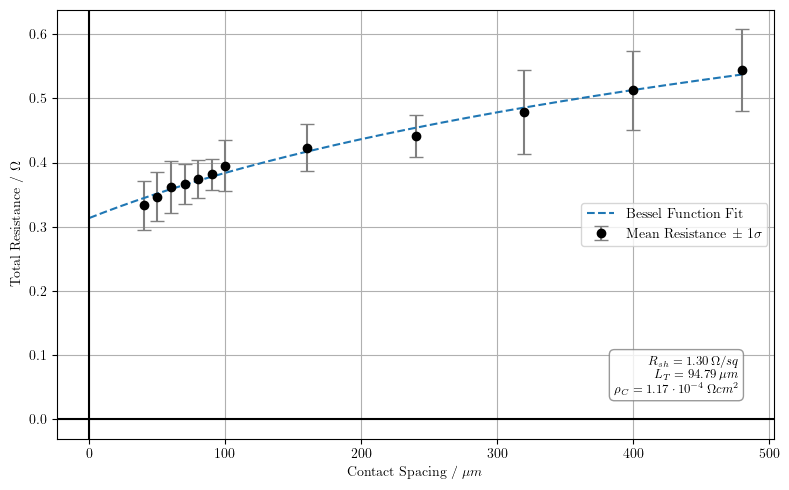

In [12]:
print(combined_R)
plt.figure(figsize=(8, 5))

all_resistances = np.array([series[1] for series in results])
means = np.mean(all_resistances, axis=0)
stds = np.std(all_resistances, axis=0)

plt.errorbar(distances, means, yerr=stds, fmt='o', color='black', 
            ecolor='gray', capsize=5, label='Mean Resistance ± 1$\\sigma$')


# fit data using the mean resistances
popt, pcov = curve_fit(ctlm_bessel_model, (distances, r_inner_array), means, p0=p0, bounds=bounds)
Rsh_fit, Lt_fit = popt
rho_c_fit = Rsh_fit * (Lt_fit**2) * 1e-8  # 1e-8 to convert from ohm·μm² to ohm·cm²

distances_smooth = np.linspace(0, max(distances), 300) # min(distances)
ri_smooth = np.full_like(distances_smooth, r_inner)
Rt_fit_curve = ctlm_bessel_model((distances_smooth, ri_smooth), Rsh_fit, Lt_fit)

plt.plot(distances_smooth, Rt_fit_curve, linestyle='--', label=f'Bessel Function Fit')


tlm_text = (
    f"$R_{{sh}} = {Rsh_fit:.2f} \\, \\Omega / sq$\n"
    f"$L_T = {Lt_fit:.2f} \\, \\mu m$\n"
    f"$\\rho_C = {sci_notation_latex(rho_c_fit)} \\, \\Omega cm^2$"
)

plt.gca().text(
    0.95, 0.1, tlm_text,
    fontsize=9,
    transform=plt.gca().transAxes,
    verticalalignment='bottom',
    horizontalalignment='right',
    bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.8, edgecolor='gray')
)

plt.axhline(0, color='black', linewidth=1.5)
plt.axvline(0, color='black', linewidth=1.5)

plt.xlabel("Contact Spacing / $\\mu m$")
plt.ylabel("Total Resistance / $\\Omega$")
plt.legend()
plt.tight_layout()
plt.grid(True)
# plt.savefig(f'Output/{name}_bessel.png')
plt.show()

[(np.float64(0.28314506309060194), np.float64(0.3765572111043252), np.float64(0.3394969284479954)), (np.float64(0.3015059097022716), np.float64(0.3961137545936529), np.float64(0.34341553770736344)), (np.float64(0.31975874913681873), np.float64(0.41780223406572076), np.float64(0.34837264307193)), (np.float64(0.322660726135809), np.float64(0.388993961806196), np.float64(0.38952127445273016)), (np.float64(0.33317368318646384), np.float64(0.3970936831648432), np.float64(0.3949662253673251)), (np.float64(0.3496788107980152), np.float64(0.4069525104373337), np.float64(0.38776751539834337)), (np.float64(0.34165228515789375), np.float64(0.40913832543616324), np.float64(0.4351674695250557)), (np.float64(0.37102960524649115), np.float64(0.4514792886889319), np.float64(0.447634209552966)), (np.float64(0.39576639346224535), np.float64(0.4630186654958676), np.float64(0.4660787558839763)), (np.float64(0.4007956571252712), np.float64(0.4744894452890198), np.float64(0.5617044796700874)), (np.float64(0

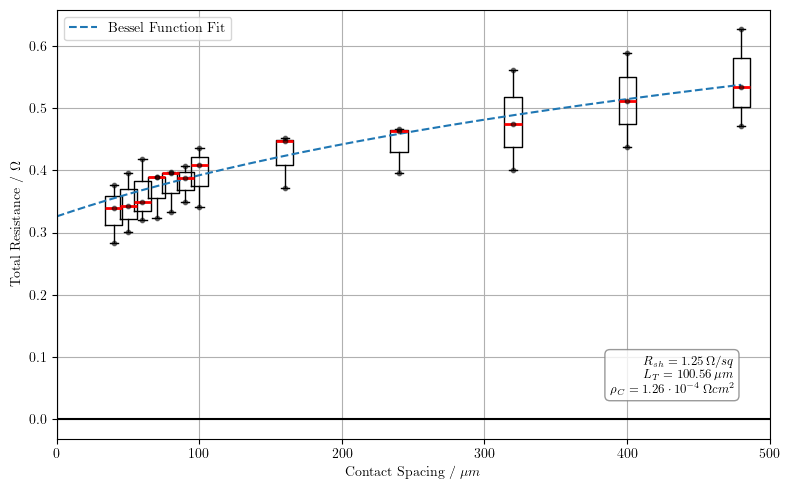

In [17]:
print(combined_R)
plt.figure(figsize=(8, 5))

plt.boxplot(combined_R, positions=distances,
            widths=12,
            # patch_artist=True,
            # boxprops=dict(facecolor='lightgray', color='black'),
            medianprops=dict(color='red', linewidth=2))

for i, x in enumerate(distances):
    y_values = combined_R[i]
    plt.scatter([x] * len(y_values), y_values, color='black', zorder=3, s=10, alpha=0.5)

resistance_matrix = np.array([series[1] for series in results])
medians = np.median(resistance_matrix, axis=0)

# fit data using the mean resistances
popt, pcov = curve_fit(ctlm_bessel_model, (distances, r_inner_array), medians, p0=p0, bounds=bounds)
Rsh_fit, Lt_fit = popt
rho_c_fit = Rsh_fit * (Lt_fit**2) * 1e-8  # 1e-8 to convert from ohm·μm² to ohm·cm²

distances_smooth = np.linspace(0, max(distances), 300) # min(distances)
ri_smooth = np.full_like(distances_smooth, r_inner)
Rt_fit_curve = ctlm_bessel_model((distances_smooth, ri_smooth), Rsh_fit, Lt_fit)

plt.plot(distances_smooth, Rt_fit_curve, linestyle='--', label=f'Bessel Function Fit')


tlm_text = (
    f"$R_{{sh}} = {Rsh_fit:.2f} \\, \\Omega / sq$\n"
    f"$L_T = {Lt_fit:.2f} \\, \\mu m$\n"
    f"$\\rho_C = {sci_notation_latex(rho_c_fit)} \\, \\Omega cm^2$"
)

plt.gca().text(
    0.95, 0.1, tlm_text,
    fontsize=9,
    transform=plt.gca().transAxes,
    verticalalignment='bottom',
    horizontalalignment='right',
    bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.8, edgecolor='gray')
)

import matplotlib.ticker as ticker
plt.xlim(0, 500)
plt.xticks(np.arange(0, 501, 100)) # This defines WHERE the ticks are
plt.gca().xaxis.set_major_formatter(ticker.ScalarFormatter())

plt.axhline(0, color='black', linewidth=1.5)
plt.axvline(0, color='black', linewidth=1.5)

plt.xlabel("Contact Spacing / $\\mu m$")
plt.ylabel("Total Resistance / $\\Omega$")
plt.legend()
plt.tight_layout()
plt.grid(True)
# plt.savefig(f'Output/{name}_bessel.png')
plt.show()